# Analysis of the impact of metro station location on commuter bikeshare habits
In this notebook I will attempt to answer the following questions using 1 year (~3.25 million rides in 386MB) of Capital Bikeshare data

* how does weekend vs. weekday bike share ridership vary?
* how does bike share ride frequency change throughout the day?
* how does rush hour ridership compare to non-rush hour?
* how do the most popular stations and routes vary between these different time windows?
* how does ride distance vary between these windows?
* can we identify gaps in service by looking at how far a commuter is willing to ride a bike?
* can we correlate any changes in ridership to delays along certain metro lines?

In [1]:
import pickle
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from geopy.distance import vincenty
import folium
matplotlib.style.use('ggplot')
%matplotlib inline

Load data which has been previous imported and cleaned in other notebooks
* `bike_location` is a dictionary of all Capital Bikeshare stations (key) and their geo-coordinates (value)
* `station_data` is a 2D dictionary of the metro stations (2nd level key) along each line (1st level key) and their geo-coordinates (2nd level values)
* `metro_delays` is a pandas dataframe listing every delay time, affect line, and duration from WMATA 
* `bikeshare_rides` is a pandas dataframe listing every ride for the most recent available year (2015-Q4 through 2016-Q3)

In [2]:
bike_location = pickle.load(open("bike_location.p", "rb"))
station_data = pickle.load(open("station_data.p", "rb"))
metro_delays = pickle.load(open("metro_delays.p", "rb"))
bikeshare_rides = pickle.load(open("bikeshare_rides_all.p", "rb"))

create list of all bike share stations to which I have location data then drop all rides which utilize one of these stations

In [3]:
bikestation_list = []
for key in bike_location:
    bikestation_list.append(key)

In [4]:
print('There are {:.0f} total rides in the data'.format(len(bikeshare_rides)))
bikeshare_rides = bikeshare_rides.where(bikeshare_rides['Start station'].str[:].isin(bikestation_list)).dropna()
bikeshare_rides = bikeshare_rides.where(bikeshare_rides['End station'].str[:].isin(bikestation_list)).dropna()
print('There are {:.0f} rides to which we have location data'.format(len(bikeshare_rides)))

There are 3268722 total rides in the data
There are 3149318 rides to which we have location data


create some columns to help with indexing later

In [5]:
bikeshare_rides['Hour'] = bikeshare_rides.index.hour
bikeshare_rides['Minute'] = bikeshare_rides.index.minute
bikeshare_rides['Day'] = bikeshare_rides.index.weekday_name
bikeshare_rides['Route'] = bikeshare_rides['Start station'] + " to " + bikeshare_rides['End station']
business_days = pd.bdate_range(bikeshare_rides.index.min(), bikeshare_rides.index.max())
weekend_days = len(business_days) / 5 * 2
print('Number of weekend days:    {}'.format(int(weekend_days)))
print('Number of weekday days:    {}'.format(int(len(business_days))))

Number of weekend days:    104
Number of weekday days:    262


Now let's determine which bikeshare stations are within a given distance to ANY metro station.  
Then we can create a flag which indicates if a each bikeshare ride orginates, or terminates, near a metro station (this will be useful later on in our analysis)

In [7]:
def close_stations(distance):
    """This fn will return a dict of bikeshare stations close 
    to each metro stop based on the suppled distance in miles"""
    lines = ['RD', 'YL', 'GR','BL', 'OR', 'SV']
    bikes_close = dict()
    for ii in range(len(lines)):
        bikes_temp = []
        for key_metro in station_data[lines[ii]]:
            for key_bike in bike_location:
                dist = vincenty(station_data[lines[ii]][key_metro], bike_location[key_bike]).miles
                if dist <= distance:
                    bikes_temp.append(key_bike)
                    #print([lines[ii], key_metro, key_bike, dist])
        bikes_close[lines[ii]] = list(set(bikes_temp))
    return bikes_close


In [8]:
stations_close_dict = close_stations(0.15)

In [9]:
nearby_stations = []
for key in stations_close_dict:
    nearby_stations = nearby_stations + stations_close_dict[key]

nearby_stations = list(set(nearby_stations))
print('This is how many bike share stations are considered "nearby":    {}'.format(str(len(nearby_stations))))
print('This is how many bike share stations are considered "far":    {}'.format(str(len(bike_location))))

This is how many bike share stations are considered "nearby":    86
This is how many bike share stations are considered "far":    441


In [10]:
bikeshare_rides['Start dist'] = np.nan
mask = bikeshare_rides['Start station'].isin(nearby_stations)
bikeshare_rides['Start dist'] = bikeshare_rides['Start dist'].where(~mask, other='near')
bikeshare_rides['Start dist'] = bikeshare_rides['Start dist'].where(mask, other='far')

bikeshare_rides['End dist'] = np.nan
mask = bikeshare_rides['End station'].isin(nearby_stations)
bikeshare_rides['End dist'] = bikeshare_rides['End dist'].where(~mask, other='near')
bikeshare_rides['End dist'] = bikeshare_rides['End dist'].where(mask, other='far')

Define functions which were initally written and tested in other notebooks

In [11]:
def line_map(line, bikestations = stations_close_dict):
    map_osm = folium.Map(location=[38.889931, -77.009003], tiles='Stamen Toner',
           zoom_start=13)
    for key in station_data[line]:
        folium.Marker(station_data[line][key], popup= key, 
                      icon=folium.Icon(color='green')).add_to(map_osm)
    for ii in range(len(bikestations[line])):
        folium.Marker(bike_location[bikestations[line][ii]], popup= bikestations[line][ii], 
                      icon=folium.Icon(color='red')).add_to(map_osm)
    return map_osm

def route_dist(x, y):
    """ this will return the distance between two point using the vincenty method
    This method is meant to be 'applied' to a dataframe"""
    start = bike_location[x]
    end = bike_location[y]
    return vincenty(start, end).miles

What is the ratio of Registered vs. Casual riders for all rides during this 1 year period?

In [12]:
bikeshare_rides.groupby("Member Type")['Member Type'].count()

Member Type
Casual         628777
Registered    2520541
Name: Member Type, dtype: int64

In [13]:
print('{:.0f}% of all rides are from Registered riders'.format((bikeshare_rides.groupby("Member Type")['Member Type']
                                                                .count().iloc[1]) / len(bikeshare_rides)*100))

80% of all rides are from Registered riders


Slice bikeshare data to get the following 'windows':
* weekdays
* weekends

In [14]:
bikeshare_weekday = bikeshare_rides[bikeshare_rides['Day'].str[0].isin(list('MTWF'))]
bikeshare_weekend = bikeshare_rides[~bikeshare_rides['Day'].str[0].isin(list('MTWF'))]

In [15]:
print(bikeshare_weekday['Day'].unique())
print(bikeshare_weekend['Day'].unique())

['Thursday' 'Friday' 'Monday' 'Tuesday' 'Wednesday']
['Saturday' 'Sunday']


Now that we have the different 'windows' to look at weekday vs weekend 24 hour periods


In [16]:
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days))

Hour
0       46.160305
1       21.015267
2       10.770992
3        5.179389
4        8.400763
5       71.961832
6      241.030534
7      651.832061
8      969.541985
9      459.221374
10     266.519084
11     308.862595
12     382.763359
13     377.240458
14     352.446565
15     417.874046
16     639.324427
17    1103.553435
18     931.603053
19     606.026718
20     420.648855
21     293.851145
22     203.454198
23     116.610687
Name: Hour, dtype: float64

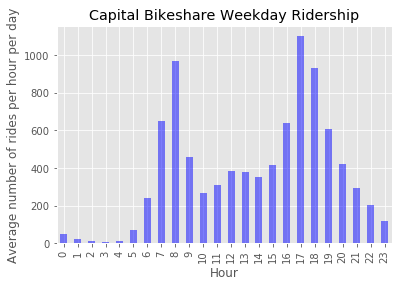

In [17]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Ridership')
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', ax=ax)

In [18]:
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days)

Hour
0     119.103053
1      84.017176
2      54.704198
3      28.721374
4      11.183206
5      13.435115
6      37.070611
7      90.553435
8     202.528626
9     352.748092
10    503.692748
11    608.177481
12    680.248092
13    684.933206
14    683.444656
15    672.185115
16    641.326336
17    580.333969
18    498.664122
19    401.125954
20    308.320611
21    231.440840
22    178.120229
23    119.933206
Name: Hour, dtype: float64

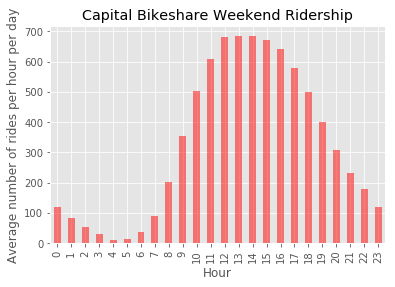

In [19]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekend Ridership')
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', ax=ax)
plt.show()

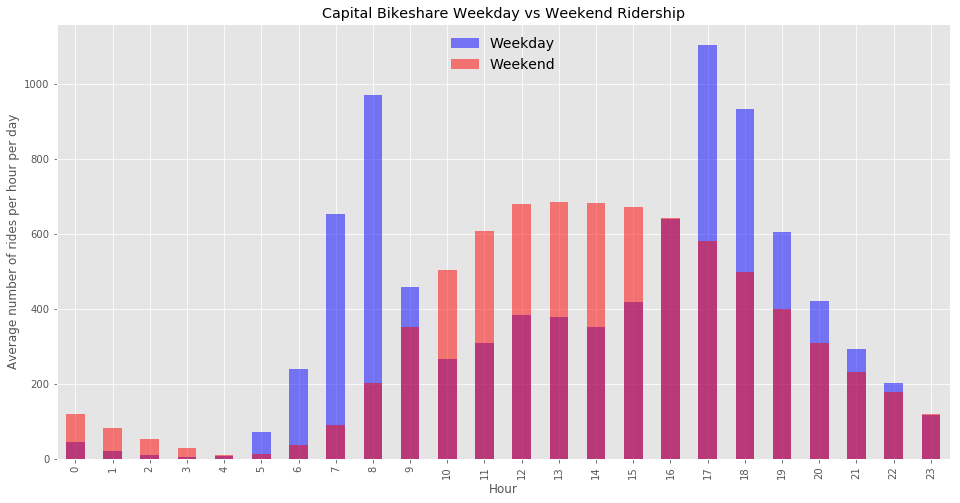

In [20]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday vs Weekend Ridership')
(bikeshare_weekday.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekday")
(bikeshare_weekend.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekend")
plt.legend(frameon=False, fontsize=14, loc=9)

A couple clear take aways, There are two spikes during the work week, one for each rush hour (centered on 8AM and 5PM), where as the weekend data just shows gradual changes with a max between 12:00 PM abd 3:00 PM  

What can we learn about 'Registered' vs 'Casual' riders during each of these time frames?  

(Capital Bikeshare groups their riders based on if they have a long term (registered; Annual Member, 30-Day Member or Day Key Member) or short term (casual; Single Trip, 24-Hour Pass, 3-Day Pass or 5-Day Pass) membership

In [21]:
bikeshare_weekday_casual = bikeshare_weekday[bikeshare_weekday['Member Type'] == 'Casual']
bikeshare_weekday_registered = bikeshare_weekday[bikeshare_weekday['Member Type'] == 'Registered']
bikeshare_weekend_casual = bikeshare_weekend[bikeshare_weekend['Member Type'] == 'Casual']
bikeshare_weekend_registered = bikeshare_weekend[bikeshare_weekend['Member Type'] == 'Registered']

In [22]:
print("Average rides of each type per day \n")
print('Weekday Casual: {}'.format(int(len(bikeshare_weekday_casual) / len(business_days))))
print('Weekday Registered: {}'.format(int(len(bikeshare_weekday_registered) / len(business_days))))
print('Weekend Casual: {}'.format(int(len(bikeshare_weekend_casual) / weekend_days)))
print('Weekend Registered: {}'.format(int(len(bikeshare_weekend_registered) / weekend_days)))

Average rides of each type per day 

Weekday Casual: 1316
Weekday Registered: 7589
Weekend Casual: 2707
Weekend Registered: 5078


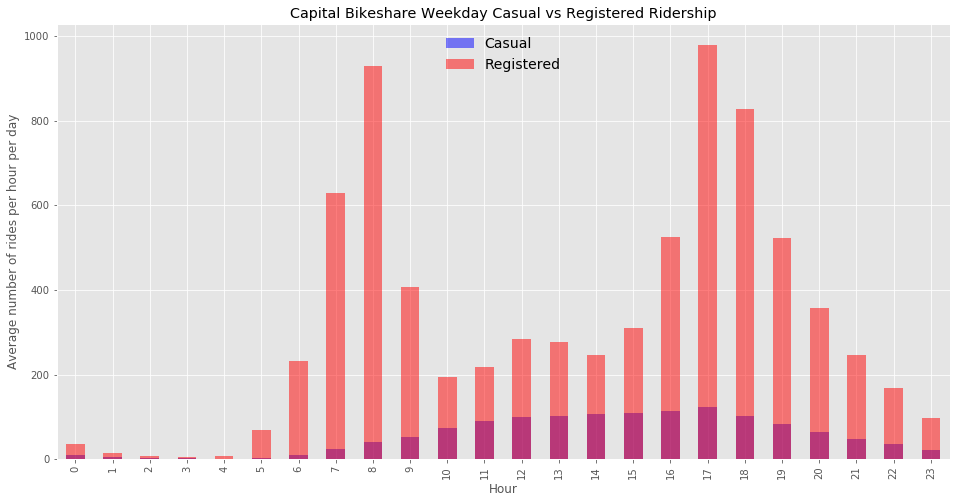

In [23]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekday Casual vs Registered Ridership')
(bikeshare_weekday_casual.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Casual")
(bikeshare_weekday_registered.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Registered")
plt.legend(frameon=False, fontsize=14, loc=9)

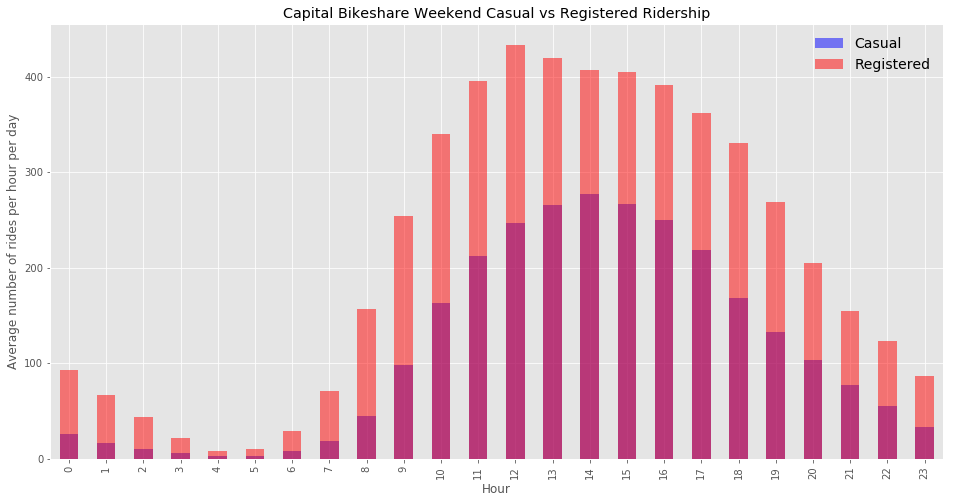

In [24]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Weekend Casual vs Registered Ridership')
(bikeshare_weekend_casual.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Casual")
(bikeshare_weekend_registered.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Registered")
plt.legend(frameon=False, fontsize=14, loc=1)

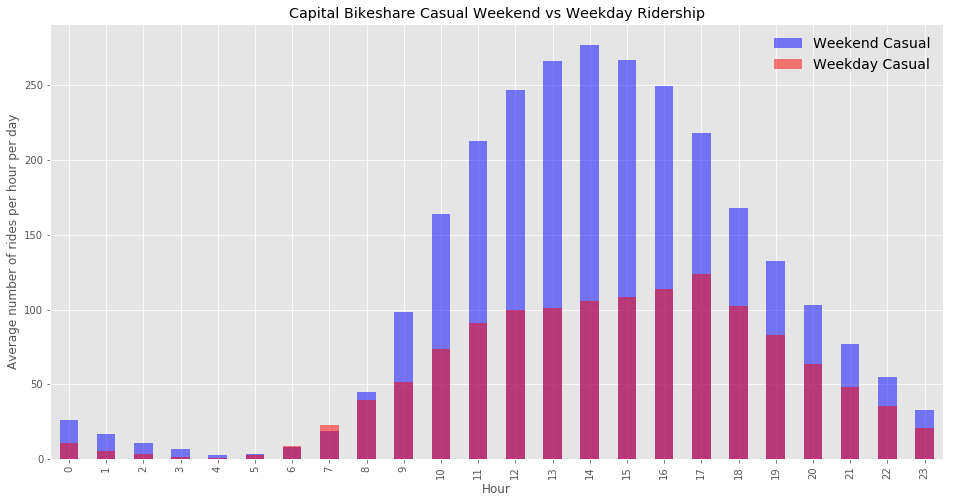

In [25]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Casual Weekend vs Weekday Ridership')
(bikeshare_weekend_casual.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekend Casual")
(bikeshare_weekday_casual.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekday Casual")
plt.legend(frameon=False, fontsize=14, loc=1)

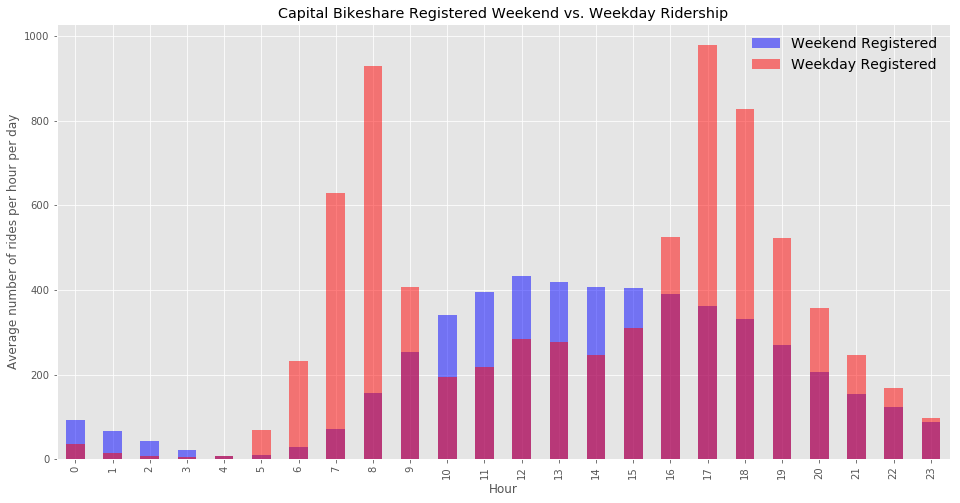

In [106]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Registered Weekend vs. Weekday Ridership')
(bikeshare_weekend_registered.groupby('Hour')['Hour'].count() / weekend_days).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Weekend Registered")
(bikeshare_weekday_registered.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Weekday Registered")
plt.legend(frameon=False, fontsize=14, loc=1)

Take aways:
* There are more registered than casual riders on both the weekends and weekdays.
* during the work week, registered users clearly follow the 'rush hour' pattern, while the casual riders follow a more 'weekend' pattern. There does appear to be a slight jump in casual rides during the evening rush hour.
* on the weekends, the difference in pattern shape between registered and casual riders is minimal, only the volume of rides is significantly different.
* There are many more causal riders on the weekends than on weekdays (~ 2x), but they follow the same pattern shape during both windows.
* There are about 33% fewer registered weekend riders than weekday riders. This suggets that many of the registered riders are commuters who use the Capital Bikeshare system to get to work.

Now, lets slice up the data based on the rush hour patterns for registered used that we saw above.
* weekday morning rush hour (6:00 - 9:59 AM)
* weekday afternoon rush hour (4:00 - 7:59 PM)
* weekday non-rush hour

In [27]:
bikeshare_morning_rush = bikeshare_weekday_registered[(bikeshare_weekday_registered['Hour'] >= 6) & 
                                                      (bikeshare_weekday_registered['Hour'] <= 9)]
bikeshare_evening_rush = bikeshare_weekday_registered[(bikeshare_weekday_registered['Hour'] >= 16) & 
                                                      (bikeshare_weekday_registered['Hour'] <= 19)]
bikeshare_no_rush = bikeshare_weekday_registered[~((bikeshare_weekday_registered['Hour'] >= 16) & 
                                                   (bikeshare_weekday_registered['Hour'] <= 19)) & 
                                                 ~((bikeshare_weekday_registered['Hour'] >= 6) & 
                                                   (bikeshare_weekday_registered['Hour'] <= 9))]


In [28]:
print(bikeshare_morning_rush['Hour'].unique())
print(bikeshare_evening_rush['Hour'].unique())
print(bikeshare_no_rush['Hour'].unique())

[6 7 8 9]
[16 17 18 19]
[ 0  1  2  3  4  5 10 11 12 13 14 15 20 21 22 23]


#### Now, what can we learn about effect of the proximity of certain bike share stations to metro stations?

Create label for each trip indicating if it originated or concluded near a metro station  
1) determine which bike share stations are within 0.15 miles of a metro station

In [29]:
bikeshare_morning_rush_close = bikeshare_morning_rush[bikeshare_morning_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_morning_rush_far = bikeshare_morning_rush[~bikeshare_morning_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_close = bikeshare_evening_rush[bikeshare_evening_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_far = bikeshare_evening_rush[~bikeshare_evening_rush['Start station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_no_rush_close = bikeshare_no_rush[bikeshare_no_rush['Start station']
                                            .str[:].isin(nearby_stations)]
bikeshare_no_rush_far = bikeshare_no_rush[~bikeshare_no_rush['Start station']
                                          .str[:].isin(nearby_stations)]

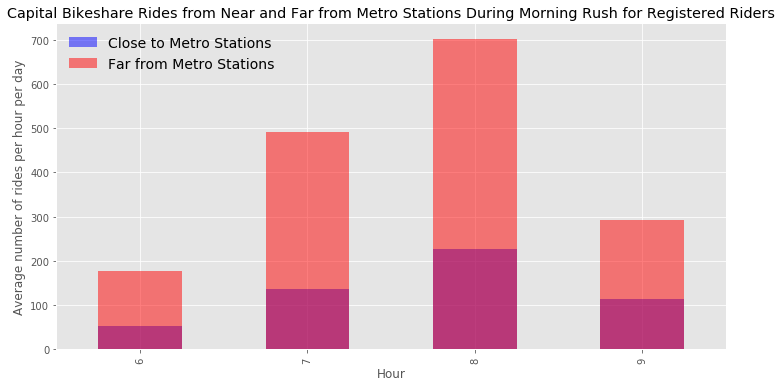

In [30]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides from Near and Far from Metro Stations During Morning Rush for Registered Riders')
(bikeshare_morning_rush_close.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_morning_rush_far.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [31]:
print('This is how many bike trips started from close to a metro station: {}'
      .format(str(len(bikeshare_morning_rush_close))))
print('This is how many bike trips started from far from a metro station: {}'
      .format(str(len(bikeshare_morning_rush_far))))
print('{:.2f}% of rides orginiated from {:.2f}% of stations'.format((len(bikeshare_morning_rush_close)/len(bikeshare_morning_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips started from close to a metro station: 139917
This is how many bike trips started from far from a metro station: 436334
24.28% of rides orginiated from 19.50% of stations


The fact that 20% of bike stations (those within 0.15 miles of a metro station) account for ~ 25% of outgoing rides during the morning rush suggest that many commuters use the two transportation systems together.

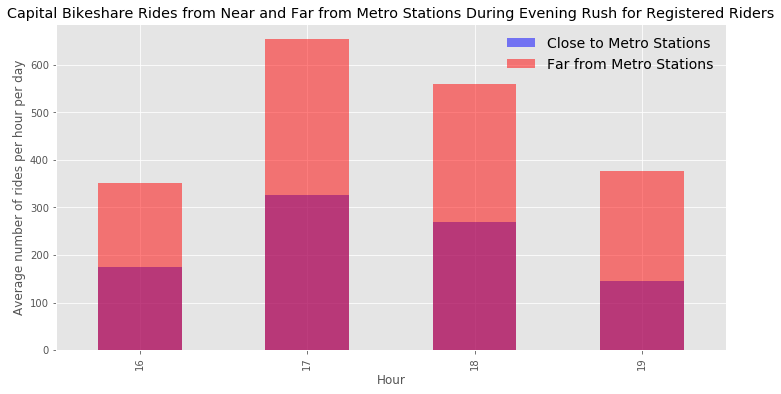

In [32]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides from Near and Far from Metro Stations During Evening Rush for Registered Riders')
(bikeshare_evening_rush_close.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_evening_rush_far.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=1)

In [33]:
print('This is how many bike trips started from close to a metro station: {}'
      .format(str(len(bikeshare_evening_rush_close))))
print('This is how many bike trips started from far from a metro station: {}'
      .format(str(len(bikeshare_evening_rush_far))))
print('{:.2f}% of rides orginiated from {:.2f}% of stations'.format((len(bikeshare_evening_rush_close)/len(bikeshare_evening_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips started from close to a metro station: 239829
This is how many bike trips started from far from a metro station: 508856
32.03% of rides orginiated from 19.50% of stations


#### Nearly 1/3 of all trips during the evening rush hour originate from within 0.15 miles of metro stations
Does this mean that people do indeed use bike share together with the metro? Perhaps they ride a bike to the metro in the morning, then metro to work. In the evening, they metro to near home, then bike the rest of the way.

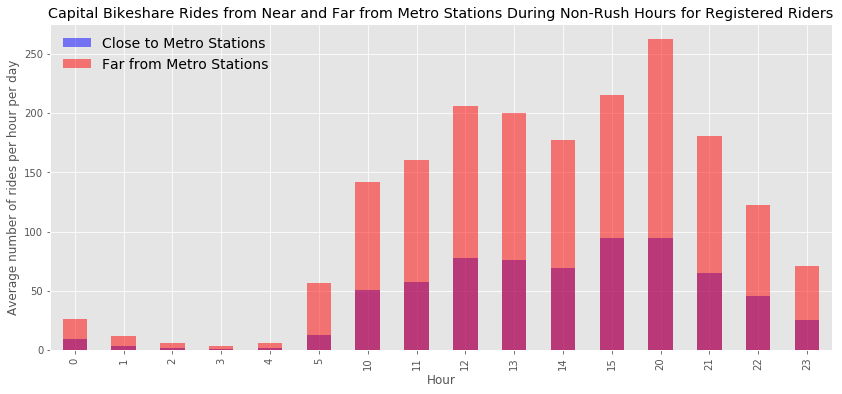

In [34]:
fig, ax = plt.subplots(figsize=[14, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides from Near and Far from Metro Stations During Non-Rush Hours for Registered Riders')
(bikeshare_no_rush_close.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_no_rush_far.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [35]:
print('This is how many bike trips started from close to a metro station: {}'
      .format(str(len(bikeshare_no_rush_close))))
print('This is how many bike trips started from far from a metro station: {}'
      .format(str(len(bikeshare_no_rush_far))))
print('{:.2f}% of rides orginiated from {:.2f}% of stations'.format((len(bikeshare_no_rush_close)/len(bikeshare_no_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips started from close to a metro station: 179409
This is how many bike trips started from far from a metro station: 483987
27.04% of rides orginiated from 19.50% of stations


What about where bike share trips conclude?

In [36]:
bikeshare_morning_rush_close_end = bikeshare_morning_rush[bikeshare_morning_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_morning_rush_far_end = bikeshare_morning_rush[~bikeshare_morning_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_close_end = bikeshare_evening_rush[bikeshare_evening_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_evening_rush_far_end = bikeshare_evening_rush[~bikeshare_evening_rush['End station']
                                                      .str[:].isin(nearby_stations)]
bikeshare_no_rush_close_end = bikeshare_no_rush[bikeshare_no_rush['End station']
                                            .str[:].isin(nearby_stations)]
bikeshare_no_rush_far_end = bikeshare_no_rush[~bikeshare_no_rush['End station']
                                          .str[:].isin(nearby_stations)]

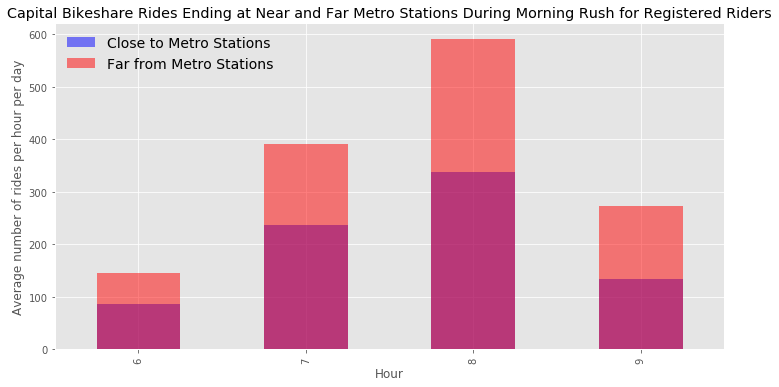

In [37]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides Ending at Near and Far Metro Stations During Morning Rush for Registered Riders')
(bikeshare_morning_rush_close_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_morning_rush_far_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [38]:
print('This is how many bike trips ended at a close metro station: {}'
      .format(str(len(bikeshare_morning_rush_close_end))))
print('This is how many bike trips ended at a far metro station: {}'
      .format(str(len(bikeshare_morning_rush_far_end))))
print('{:.2f}% of rides ending at {:.2f}% of stations'.format((len(bikeshare_morning_rush_close_end)/len(bikeshare_morning_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips ended at a close metro station: 208771
This is how many bike trips ended at a far metro station: 367480
36.23% of rides ending at 19.50% of stations


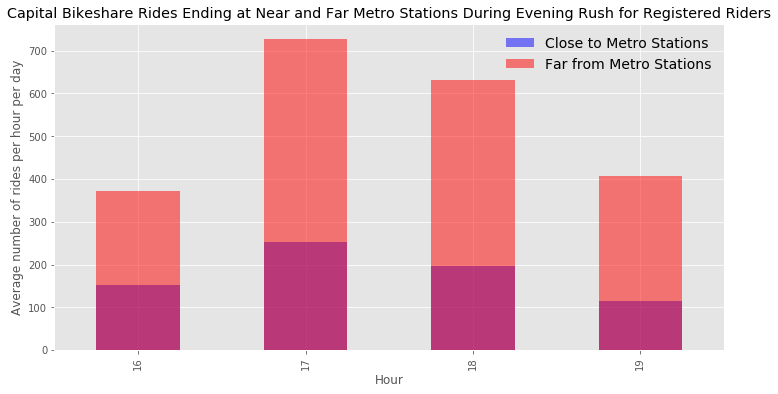

In [39]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides Ending at Near and Far Metro Stations During Evening Rush for Registered Riders')
(bikeshare_evening_rush_close_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_evening_rush_far_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=1)

In [40]:
print('This is how many bike trips ended at a close metro station: {}'
      .format(str(len(bikeshare_evening_rush_close_end))))
print('This is how many bike trips ended at a far metro station: {}'
      .format(str(len(bikeshare_evening_rush_far_end))))
print('{:.2f}% of rides ending at {:.2f}% of stations'.format((len(bikeshare_evening_rush_close_end)/len(bikeshare_evening_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips ended at a close metro station: 188184
This is how many bike trips ended at a far metro station: 560501
25.14% of rides ending at 19.50% of stations


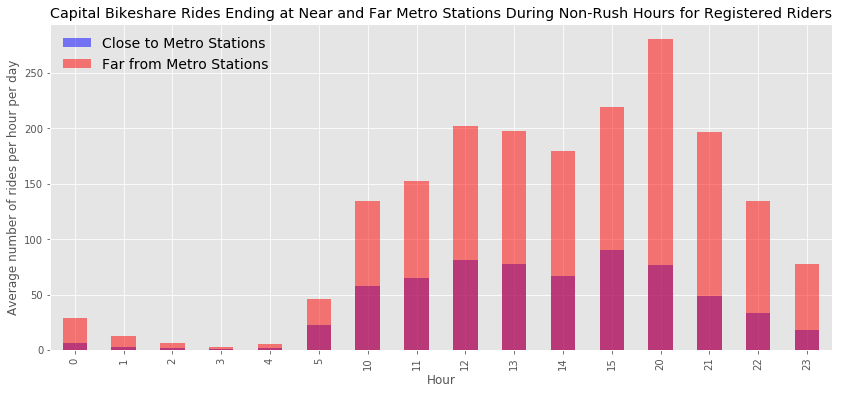

In [41]:
fig, ax = plt.subplots(figsize=[14, 6])
ax.set_ylabel('Average number of rides per hour per day')
ax.set_title('Capital Bikeshare Rides Ending at Near and Far Metro Stations During Non-Rush Hours for Registered Riders')
(bikeshare_no_rush_close_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar', alpha=0.5, color='b', 
                                                                              ax=ax,label= "Close to Metro Stations")
(bikeshare_no_rush_far_end.groupby('Hour')['Hour'].count() / len(business_days)).plot(kind='bar',alpha=0.5, color='r', 
                                                                        ax=ax, label= "Far from Metro Stations")
plt.legend(frameon=False, fontsize=14, loc=2)

In [42]:
print('This is how many bike trips ended close to a metro station: {}'
      .format(str(len(bikeshare_no_rush_close))))
print('This is how many bike trips ended far from a metro station: {}'
      .format(str(len(bikeshare_no_rush_far))))
print('{:.2f}% of rides ending at {:.2f}% of stations'.format((len(bikeshare_no_rush_close_end)/len(bikeshare_no_rush)*100), 
                                                            (len(nearby_stations)/len(bike_location)*100)))

This is how many bike trips ended close to a metro station: 179409
This is how many bike trips ended far from a metro station: 483987
25.81% of rides ending at 19.50% of stations


#### Now what can we learn from considering the distances of these trips?

In [58]:
# this step is very slow
#bikeshare_no_rush_far.apply(lambda x: route_dist(x['Start station'], x['End station']), axis=1)
bikeshare_morning_rush['Ride dist'] = bikeshare_morning_rush.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                   axis=1)

C:\Users\DDT\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
bikeshare_morning_rush['Ride dist'].describe()

count    576251.000000
mean          1.263647
std           0.817990
min           0.000000
25%           0.654141
50%           1.068510
75%           1.677147
max          12.773643
Name: Ride dist, dtype: float64

In [61]:
bikeshare_evening_rush['Ride dist'] = bikeshare_evening_rush.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                   axis=1)

C:\Users\DDT\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [62]:
bikeshare_evening_rush['Ride dist'].describe()

count    748685.000000
mean          1.157711
std           0.774916
min           0.000000
25%           0.591867
50%           0.970354
75%           1.522205
max          13.526540
Name: Ride dist, dtype: float64

In [63]:
bikeshare_no_rush['Ride dist'] = bikeshare_no_rush.apply(lambda x: route_dist(x['Start station'], x['End station']),
                                                                   axis=1)

C:\Users\DDT\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [64]:
bikeshare_no_rush['Ride dist'].describe()

count    663396.000000
mean          1.023776
std           0.712535
min           0.000000
25%           0.531176
50%           0.846326
75%           1.344000
max          13.526540
Name: Ride dist, dtype: float64

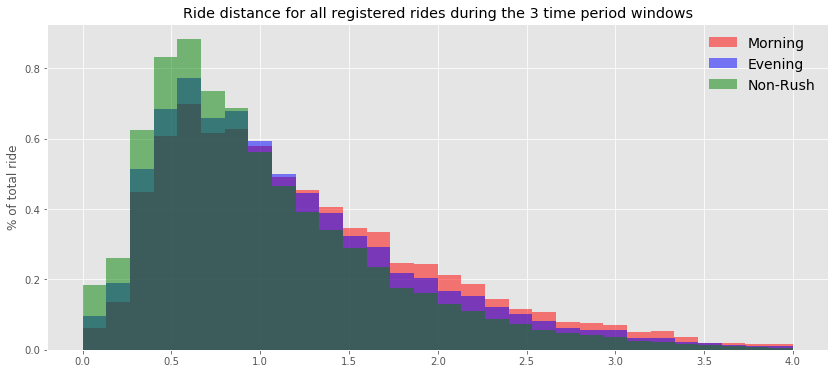

In [94]:
fig, ax = plt.subplots(figsize=[14, 6])
(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5, normed = True,
                                                                                         ax=ax, color='r', label='Morning')
(bikeshare_evening_rush[bikeshare_evening_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5, normed = True,
                                                                                         ax=ax, color='b', label='Evening')
(bikeshare_no_rush[bikeshare_no_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5, normed = True,
                                                                               ax=ax, color='g', label='Non-Rush')
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance for all registered rides during the 3 time period windows')
plt.legend(frameon=False, fontsize=14, loc=1)

While rides appear to get slightly shorter throughout the day, there is not a strong dependence.  
What about those near and far from a metro station?

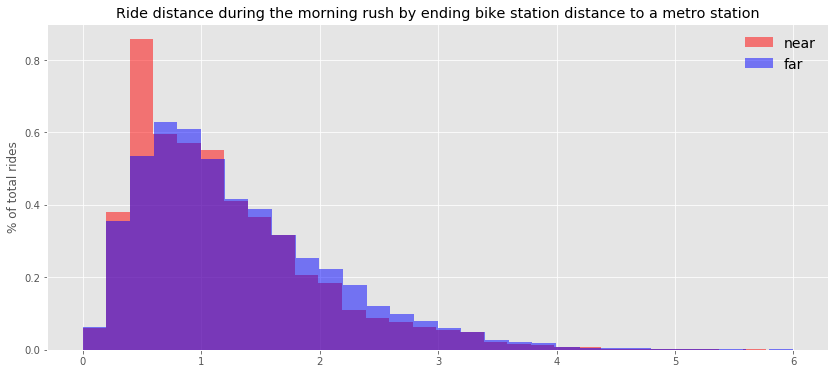

In [103]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_morning_rush.groupby('End dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='near')
temp2 = bikeshare_morning_rush.groupby('End dist').get_group('far')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='far')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the morning rush by ending bike station distance to a metro station')

There is a spike in the distances around 0.5 miles for morning rides that end at stations near metro stations. This spike is also present in evening rides beginning at near metro stations.

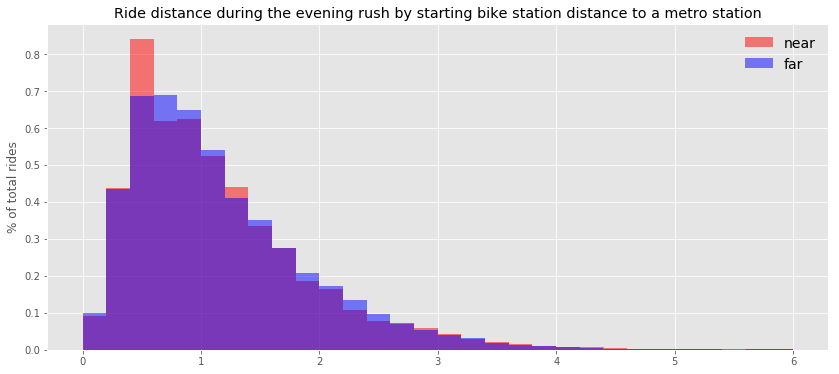

In [104]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_evening_rush.groupby('Start dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='near')
temp2 = bikeshare_evening_rush.groupby('Start dist').get_group('far')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='far')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the evening rush by starting bike station distance to a metro station')

This suggests that there are a significant number of commuters who use the bike share to travel about 0.5 miles to near metro stations in the morning, and away from metro stations in the evening

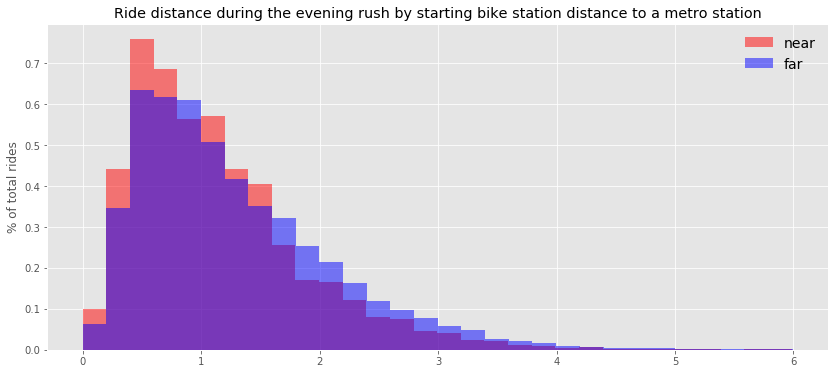

In [109]:
fig, ax = plt.subplots(figsize=[14, 6])
temp1 = bikeshare_evening_rush.groupby('End dist').get_group('near')
temp1[temp1['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='r', label='near')
temp2 = bikeshare_morning_rush.groupby('Start dist').get_group('far')
temp2[temp2['Ride dist']< 6]['Ride dist'].plot.hist(bins=30, alpha=0.5, normed=True,
                                                                                         ax=ax, color='b', label='far')

#(bikeshare_morning_rush[bikeshare_morning_rush['Ride dist'] < 4]['Ride dist']).plot.hist(bins=30, alpha=0.5,
#                                                                                         ax=ax, color='r', label='Morning')
plt.legend(frameon=False, fontsize=14, loc=1)
ax.set_ylabel('% of total rides')
ax.set_title('Ride distance during the evening rush by starting bike station distance to a metro station')